Nicholas Brower<br>
Springboard DSCT \[May 2022\]<br>
Unit 26.2.2 (Part 1)<br>

# Ultimate Technologies Inc. Take-Home Challenge<br>
## Part 1: Exploratory data analysis<br>

This notebook performs exploratory data analysis of a dataset comprised of timetamps of user logins from a particular location. Reports and visualizations are created to identify, illustrate, and describe underlying patterns and data quality issues. <br><br>

### Imports and infrastructure

Import modules and packages.

Classes, constants, and functions are defined in the ultimate_tech.py module located in the same folder as this notebook. The contents of this module are viewable in a <a href='Ultimate Technologies Inc. Take-Home Challenge Appendix.ipynb'>separate notebook file</a>.

In [1]:
from ultimate_tech import *

### Wrangling<br>
Import and analyze the provided dataset. Describe its structure, scale, completeness, redundance, datatypes and summary statistics. Identify potential data quality issues.<br>

Load the provided login data json file as a Pandas DataFrame.<br>

In [2]:
logins = pd.read_json(f'{RAW_DATA}logins.json')
logins.attrs['name'] = 'logins'

#### Structure, scale, datatypes, and completeness

Print the shape, field names and datatypes, null percentage by field, and first three records of the logins DataFrame created in the previous cell.

In [3]:
print(f'logins dataframe{BR}{hr("=")}')
print(f'shape{BR}{HR}')
for name, number in zip(('records:', 'fields:'), logins.shape):
    print(indented(f'{name:<15}{number}'))
print(f'{TAB}-{BR}datatypes{BR}{HR}')
print(
    indented(f'{"field name":<15}{"dtype":<15}{"null %":>15}')
    + f'{BR}{hr(indent_level=1)}'
)

for field, dtype in logins.dtypes.items():
    print(indented(
        f'{field:<15}{dtype.name:<15}{logins[field].isnull().mean():>15.2f}'
    ))
print(f'{TAB}-{BR}first 3 records{BR}{HR}')
print(
    indented(''.join(f'{_:<12}' for _ in ['index', *list(logins.columns)]))
    + f'{BR}{hr(indent_level=1)}'
)
for i in range(3):
    print(indented(
        ''.join(f'{_:<12}' for _ in [i, *map(str, logins.iloc[i].values)])
    ))

logins dataframe
shape
-------------------------------------------------------------------------------
    records:       93142
    fields:        1
    -
datatypes
-------------------------------------------------------------------------------
    field name     dtype                   null %
    ---------------------------------------------------------------------------
    login_time     datetime64[ns]            0.00
    -
first 3 records
-------------------------------------------------------------------------------
    index       login_time  
    ---------------------------------------------------------------------------
    0           1970-01-01T20:13:18.000000000
    1           1970-01-01T20:16:10.000000000
    2           1970-01-01T20:16:37.000000000


The provided dataset has a single field. This field, <span style='font-family:monospace;color:rgb(0, 100, 0);'>login_time</span>, consists of datetime values. No records are null. The first 3 records show datetime values from 1970. The year component of these timestamps should be further investigated.<br>

#### Statistical overview<br>
Print summary statics of datetime values in the <span style='font-family:monospace;color:rgb(0, 100, 0);'>login_time</span> field.

In [4]:
print(f'logins: summary statistics{BR}{hr("=", 71)}')
intervals = ['year', 'month', 'day', 'hour', 'minute', 'second']
print(f'{"stat":<10}{"".join(f"{_:>10}" for _ in intervals)}{BR}{hr("-", 71)}')
for ag, v in logins.login_time.describe(datetime_is_numeric=True)[1:].items():
    print(
        f'{ag:<10}' + "".join(f"{str(getattr(v, i)):>10}" for i in intervals)
    )
print(HR[:71])
for ordinal, agg in zip(['first', 'last'], ['min', 'max']):
    agg = getattr(logins.login_time, agg)().strftime('%B %d, %Y')
    print(f'{f"{ordinal} login date:":<20}{agg}')
logins_span = np.subtract(*logins.login_time.agg(['max', 'min']))
logins_span = divmod(logins_span.total_seconds()/60/60, 24)
logins_span = f'{logins_span[0]:.0f} days, {np.ceil(logins_span[1]):.0f} hours'
print(f'{"dataset span:":<20}{logins_span}')

logins: summary statistics
stat            year     month       day      hour    minute    second
-----------------------------------------------------------------------
mean            1970         2        26        19         9        39
min             1970         1         1        20        12        16
25%             1970         2         4        10        37        19
50%             1970         3         1         6        33         5
75%             1970         3        22         4         1        10
max             1970         4        13        18        57        38
-----------------------------------------------------------------------
first login date:   January 01, 1970
last login date:    April 13, 1970
dataset span:       101 days, 23 hours


All timestamps in the <span style='font-family:monospace;color:rgb(0, 100, 0);'>login_time</span> field describe logins that took place in the inclusive interval of January 1st to April 13th of the year 1970. This dataset records logins that take place during a span of roughly 102 days.<br><br>
The year component of these timestamps may be erroneous. The single year represented in this dataset is equal to the year component of the Unix epoch. It seems unlikely that the timestamps in this dataset were logged more than half a century ago. Given the nature of this assignment, it seems more likely that these timestamps are associated with logins that took place within the last several years. The year component of the provided timestamps may have been recorded as 1970 because of an error or oversight during the collection, processing, or distribution of this data.<br><br>
Ensure data has been loaded properly within this notebook by printing the first 200 characters of the <span style='font-family:monospace;color:rgb(0, 100, 0);'>logins.json</span> file.

In [5]:
with open (f'{RAW_DATA}logins.json') as logins_json_file:
    print('\n'.join(textwrap.wrap(logins_json_file.read(200), 70)))

{"login_time": ["1970-01-01 20:13:18", "1970-01-01 20:16:10",
"1970-01-01 20:16:37", "1970-01-01 20:16:36", "1970-01-01 20:26:21",
"1970-01-01 20:21:41", "1970-01-01 20:12:16", "1970-01-01 20:35:47",


The year of all visible timestamps shown above is 1970, indicating the <span style='font-family:monospace;color:rgb(0, 100, 0);'>logins.json</span> file was loaded as provided.<br>

Determine if the average number of logins varies by day of the week. If average logins for two consecutive days of the week have simliar values that are distinct from the other five days of the week, it is reasonable to suspect these two days are Saturday and Sunday. The actual year of the collected data may be estimated if such a pattern exists. To perform this test, create bar plots of aveage login counts grouped by weekday and hour of the week. <br><br>
First, create a subset of  records excluding the first and last date. The times of the first and last timestamps of the logins dataset indicate that data collection may not have been complete on the first and last dates. Create a subset of logins excluding all timestamps from these two days.

In [6]:
logins.sort_values(by='login_time', inplace=True)
not_1st_or_last = ~logins.login_time.dt.date.isin(
    logins.login_time.dt.date.agg(['min', 'max'])
)
subset = logins.copy()[not_1st_or_last]
print(f'subset: first and last timestamps{BR}{hr("=", 33)}')
print(
    subset.login_time.agg(['min', 'max'])
    .rename({'min': 'first', 'max': 'last'}).to_string()
)

subset: first and last timestamps
first   1970-01-02 00:01:54
last    1970-04-12 23:59:55


Count the number of unique dates per weekday in this dataset. Use the reindex method of the resulting series to generate similar counts for each hour of the week.

In [7]:
weekday_occurrences = (
    subset.login_time.dt.date
    .groupby(subset.login_time.dt.weekday).nunique()
)
hour_of_week_occurrences = (
    pd.Series(
       weekday_occurrences.values, index=weekday_occurrences.index*24
    ).reindex(range(24*7), method='ffill')
    .rename('hour_of_week_occurrences')
)
assert hour_of_week_occurrences.sum()==(weekday_occurrences*24).sum()
print(f'{"day":<5}{"count":>5}{BR}{hr("=", 10)}')
for weekday, count in weekday_occurrences.items():
    print(f'{weekday:<5}{count:>5,.0f}')


day  count
0       14
1       14
2       14
3       14
4       15
5       15
6       15


Count the numer of timestamps grouped by weekday and hour of the week.

In [8]:
login_count_by_weekday = subset.login_time.dt.weekday.value_counts().sort_index()
login_count_by_hour_of_week = (
    subset.login_time.groupby(
        [24*subset.login_time.dt.weekday + subset.login_time.dt.hour]
    ).count()
)

Divide the counts established above by their corresponding occurrence series to calculate average logins per interval. Depict these averages as bar plots.

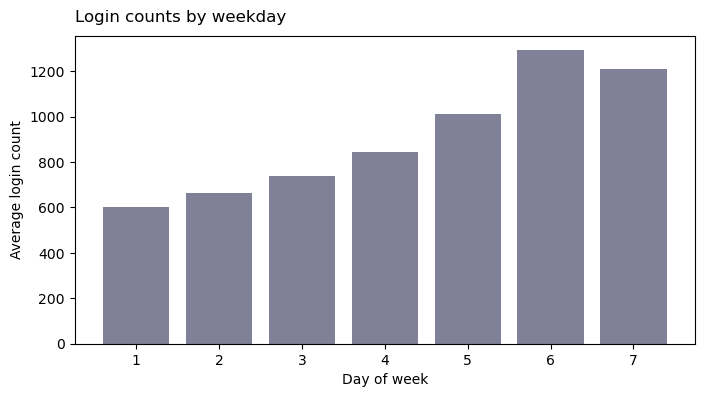

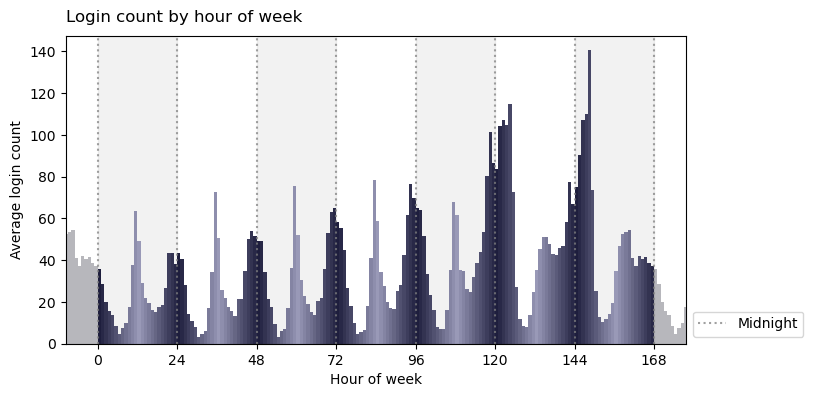

In [9]:
# Plot login counts grouped by weekday
fig, ax = plt.subplots(figsize=(8, 4))
set_plot_title('Login counts by weekday')
ax.bar(
    login_count_by_weekday.index, login_count_by_weekday/weekday_occurrences, 
    align='center', width=0.8, color=(0.5, 0.5, 0.6), 
    zorder=0, label='Daily average login count'
)
ax.set_xticks(range(7), range(1, 8))
ax.set_xlabel('Day of week'); ax.set_ylabel('Average login count')

# Plot login counts grouped by hour of the week
fig, ax = plt.subplots(figsize=(8, 4))
set_plot_title('Login count by hour of week')

# Modulate fill luminance with time of day
grad_color = colormap.binary(
    abs(12 - (login_count_by_hour_of_week.index%24))/15
)
weekday_by_hour = login_count_by_hour_of_week/hour_of_week_occurrences
for color in (grad_color, (0, 0, 0.3, 0.4)):
    ax.bar(
        login_count_by_hour_of_week.index.values/24, 
        weekday_by_hour, width=1/24, align='edge', color=color
    )

# Wrap the first and last 12 hours of data
looped_data = weekday_by_hour.iloc[-12:], weekday_by_hour.iloc[:12]
looped_inds = (np.arange(-12, 0), np.arange(24 * 7, 24 * 7 + 12))
for ind, data in zip(looped_inds, looped_data):
    ax.bar(ind/24, data, width=1/24, align='edge', color=(0.2, 0.2, 0.25, 0.35), zorder=-1)

# Add ticks; add dotted lines at day boundaries
ax.set_xticks(np.arange(8), np.arange(8) * 24)
yh = ax.get_ylim()[1]
for midnight in np.arange(8):
    kwarg = {'label': 'Midnight'} if midnight==7 else {}
    ax.axvline(midnight, color=(0.5, 0.5, 0.5, 0.75), ls=':', **kwarg)
    if not midnight%2:
        ax.fill_between(
            [midnight, midnight + 1], yh, color=(0.5, 0.5, 0.5, 0.1), zorder=-2
        )
    
# Set limits and labels; add legend; show plots
ax.set_xlim(-0.4, 7.4); ax.set_ylim(0, yh)
ax.set_xlabel('Hour of week'); ax.set_ylabel('Average login count')
ax.legend(loc='lower left', bbox_to_anchor=(1, 0))
del grad_color, yh, looped_inds, looped_data
plt.show();

The plots of average logins per day of the week and average logins per hour of the week demonstrate important pattens. The last three of the seven days depicted in the top plot have significantly higher averages than the first four. In the lower plot, average logins by hour of the week peak between the evening of day 6 and morning of day 7. The unmodified time series as depicted above represents a plausible arrangement of days, with Monday as day 1 and Sunday as day 7. This places peak demand late on Saturday evenings.<br><br>
Create a dictionary pairing names of times of day with ranges of hours to facilitate the depiction of login counts by weekday and time of day .<br>

In [10]:
after_midnight = range(3)
early_morning = range(3, 6)
morning = range(6, 9)
daytime = range(9, 12)
afternoon = range(12, 15)
early_evening = range(15, 18)
evening = range(18, 21)
latenight = range(21, 24)
times_of_day = dict(zip(
    [
        'after midnight', 'before dawn', 'early morning', 
        'morning', 'afternoon', 'early evening', 'evening',
        'late at night'
    ], [
        after_midnight, early_morning, morning, daytime, afternoon,
        early_evening, evening, latenight
    ]
))

Plot login counts grouped by weekday for each of several timeframes during a given day.

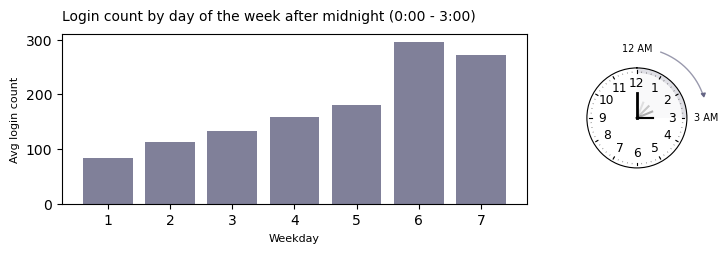

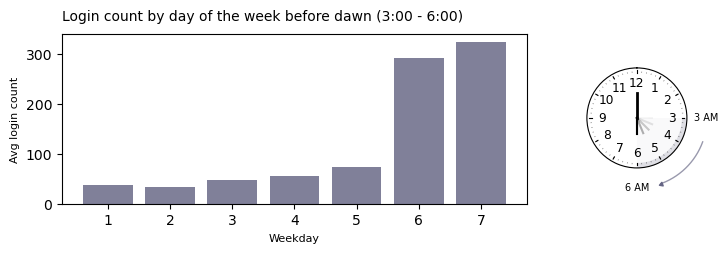

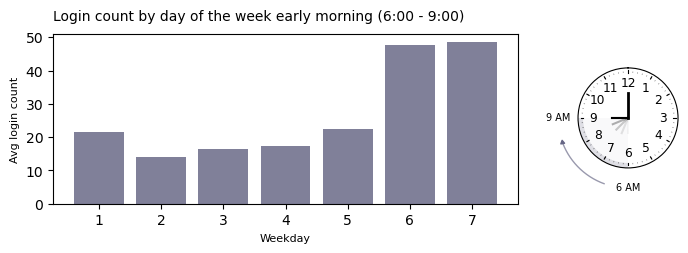

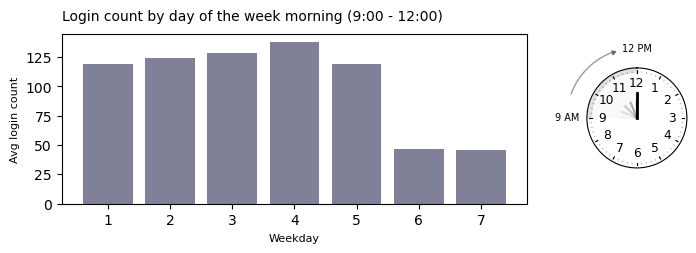

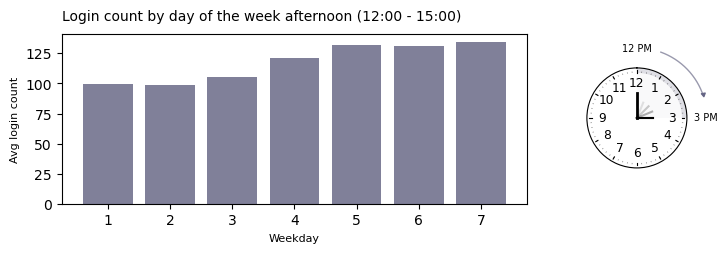

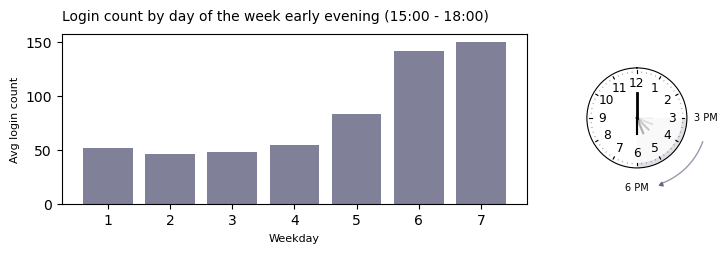

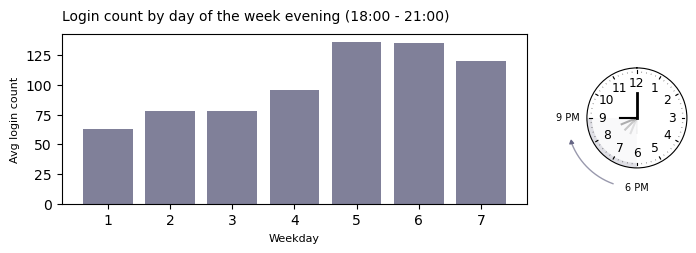

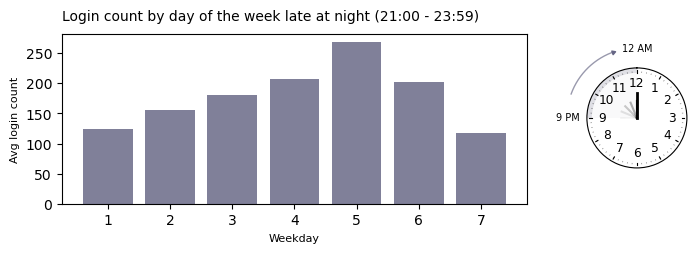

In [11]:
twelve_hour_times = [
    f'{hour:.0f}{am_or_pm}' 
    for hour, am_or_pm in zip(2*[12, *range(1, 12)], 12 * [' AM'] + 12*[' PM'])
]
for label, hours in times_of_day.items():
    fig, ax = plt.subplots(figsize=(6, 2.2))
    set_plot_title(
        f'Login count by day of the week {label.replace("_", " ")}'
        + f" ({min(hours)}:00 - {max(hours) + 1}:00)".replace("24:00", "23:59"), 
        fontsize=10, ax=ax
    )
    mask = subset.login_time.dt.hour.isin(hours)
    counts = subset[mask].login_time.dt.weekday.value_counts()/weekday_occurrences
    ax.bar(counts.index, counts, color=(0.5, 0.5, 0.6))
    ax.set_xticks(range(7), range(1, 8))
    ax.set_xlabel('Weekday', fontsize=8)
    ax.set_ylabel('Avg login count', fontsize=8)
    del mask, counts
    hours_rads = [*map(clock_radians, [*hours, hours[-1] + 1])]
    clock = add_clock_subplot(fig, (1, 0, 1/fig.get_figwidth(), 1))
    clock.set_xticks(
        [*map(clock_radians, [*hours, hours[-1] + 1])], 
        [twelve_hour_times[hours[0]], '', '', twelve_hour_times[(hours[-1] + 1)%24]],
        fontsize=7
    )
    for bottom, alpha in zip([0.9, 0], [0.1, 0.025]):
        clock.bar(
            pd.Series([*hours]).apply(clock_radians), np.full(3, 1),
            width=np.radians(30), ls=None, ec=None, color=(0, 0, 0.2, alpha),
            align='edge', bottom=bottom
        )
    clock.plot([0, 0], [0, 0.5], color='black', lw=2)
    for i, _ in enumerate(np.linspace(hours_rads[0], hours_rads[0] + np.deg2rad(90), 5)):
        clock.plot([_, _], [0, 0.33], color=(0, 0, 0, i/10))
    clock.plot(2 * [hours_rads[-1]], [0, 0.33], color='black')
    clock.plot(2*[hours_rads[0]], [0, 0.33], color=(0, 0, 0, 0.5), ls=':', lw=0.25)
    clock.plot(
        np.linspace(hours_rads[0] + np.deg2rad(20), hours_rads[0] + np.deg2rad(70), 1000), 
        np.full(1000, 1.4), clip_on=False, color=(0, 0, 0.2, 0.4), lw=1
    )
    clock.scatter(
        hours_rads[0] + np.deg2rad(70), 1.4, clip_on=False,
        marker=(3, 0, np.rad2deg(hours_rads[0]) + (70 if hours[0]%12 in [0, 6] else 20)),
        color=[0.4 , 0.4 , 0.52], zorder=10, s=10
    )
    plt.show();

In the plots shown above, days 1 - 5 show distinct patterns compared to days 6 and 7. Morning logins on days 6 and 7 are less than half of those of days 1 through 5. Early evening and evening logins of days 5 through 7 are significantly higher than those of days 1-4. The existing weekday values are most likely accurate. 
<br><br>
To retain this pattern of weekdays, the actual year of data collection must start with the same weekday as the year 1970. Given the lack of data for February 29th, it is unlikely the actual year of data collection is a leap year.<br><br>
Create a list of plausible years using a range. If the month and day of the current year is greater than those of the last timestamp of the logins dataset, include this calendar year in the list of candidates.

In [12]:
plausible_years = list(range(datetime.now().year - 10, datetime.now().year))
if datetime.now().date() > logins.login_time.max().date().replace(year=datetime.now().year):
    plausible_years.append(datetime.now().year)
print(f'replacement year value candidates for timestamps in logins{BR}{HR}')
print(', '.join(map(str, plausible_years)))

replacement year value candidates for timestamps in logins
-------------------------------------------------------------------------------
2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023


Filter the list of years created above. Remove all leap years, and remove all years for which January 1st is not the same weekday as it was on January 1st of 1970. 

In [13]:
plausible_years = [
    year for year in plausible_years
    if ( # Include onky years with same weekday on Jan 1st
        datetime(year=year, month=1, day=1).weekday()
        == datetime(year=1970, month=1, day=1).weekday()
    )
    and ( # Exclude leap years
        monthrange(year, 2) == monthrange(1970, 2)
    )
]
print(f'possible replacement year values for timestamps in logins{BR}{HR}')
print(', '.join(map(str, plausible_years)))

possible replacement year values for timestamps in logins
-------------------------------------------------------------------------------
2015


In the year of this notebook's creation (2023), the year 2015 is the only seemingly viable candidate. This will be noted in reports and conclusions. For simplicity, further analysis of this time series may ignore the year component of datetime values or assume it is not erroneous.<br><br>

Calculate and print summary statistics for various other datetime components of the login_time field.

In [14]:
print(f'logins: summary statistics by datetime interval{BR}{hr("=", 72)}')
stats = ['min', 'max', 'mean', 'median', 'nunique']
intervals = [
    'month', 'day', 'weekday', 'hour', 'minute', 'second', 'microsecond',
    'nanosecond'
]
print(f'{"interval":<12}{"".join(f"{_:>12}" for _ in stats)}{BR}{hr("-", 72)}')
for interval in intervals:
    i_stats = getattr(logins.login_time.dt, interval).agg(stats)
    print(
        f'{interval:<12}' + ''.join(
            f'{result:>12.{places}f}' for result, places in zip(i_stats, (0, 0, 2, 0, 0))
        )
    )
    del i_stats


logins: summary statistics by datetime interval
interval             min         max        mean      median     nunique
------------------------------------------------------------------------
month                  1           4        2.42           3           4
day                    1          31       14.67          14          31
weekday                0           6        3.57           4           7
hour                   0          23       11.64          12          24
minute                 0          59       29.80          30          60
second                 0          59       29.62          30          60
microsecond            0           0        0.00           0           1
nanosecond             0           0        0.00           0           1


Excepting microsecond and nanosecond, the number of unique values for each of the datetime components listed above is consistent with the number of possible values. Differences in mean and median values of the month and weekday components are suggestive of long and shorter-term trends.<br><br>
All of the microsecond and nanosecond values in this dataset are zero. The minimum difference between two unequal datetime values in this datasert is one second.

Create a Pandas DatetimeIndex object using the first and last dates of the logins dataset. This may be used to investigate potential data quality issues.<br>

In [15]:
logins_date_range = pd.date_range(
    *map(methodcaller('date'), logins.login_time.agg(['min', 'max'])),
    name='login_date'
)
print(
    f'logins: date range{BR}{HR[:20]}{BR}'
    + str(logins_date_range.isocalendar().agg(['min', 'max']))
)
assert all([ # Sanity check - ensure the date range covers all dates in logins
    a == b for a, b in zip(
        [logins_date_range.min().date(), logins_date_range.max().date()], 
        [*logins.login_time.dt.date.agg(['min', 'max'])]
    )
])

logins: date range
--------------------
     year  week  day
min  1970     1    1
max  1970    16    7


Use the DatetimeIndex created above to determine if there are any dates in the described period for which there are no recorded logins. Print the number of unique dates matching this criteria.

In [16]:
dates_without_logins = logins_date_range[
    ~logins_date_range.isin(logins.login_time.dt.date.unique())
]
print(f'{len(dates_without_logins)} dates have no recorded logins')


0 dates have no recorded logins


There is at least one record for each day of the date range established by the first and last login of the logins dataset.<br>

#### Duplicates

Count the number of occurrences of each unique datetime value in the logins DataFrame. Filter these results by counts greater than or equal to 2 to determine the number of duplicates in logins. Print the number of records found at each redundance level.

In [17]:
duplicate_counts = logins.login_time.value_counts()
duplicate_counts = duplicate_counts[duplicate_counts >= 2]
print(f'logins: duplicated timestamps{BR}{HR}')
for times_repeated, num_records in duplicate_counts.value_counts().items():
    print(
        f'{num_records} records are repeated {times_repeated-1} time{(times_repeated >=3)*"s"}'
        + f' (accounting for '
        + f'{100 * ((num_records * times_repeated)/len(logins)):.2f}% of all records)'
    )

logins: duplicated timestamps
-------------------------------------------------------------------------------
859 records are repeated 1 time (accounting for 1.84% of all records)
9 records are repeated 2 times (accounting for 0.03% of all records)


There are 859 unique timestamps in logins that occur twice. These accout for nearly 2% of all records. There are 9 unique timestamps in logins which occur three times.<br><br>
Without additional information, it is not possible to draw any conclusions regarding these duplicated time stamps. There is no user or unique login identifier field, and there is no information in the provided metadata that suggests concurrent logins is impossible. Given this dataset's maximum resolution of 1 second, it is possible that apparently duplicated records represent separate logins which occurred at distinct times less than one second apart. It may also be possible that duplicates exist as an artifact of the data collection method.<br><br>
To investigate potential patterns, plot dataset-wide value counts of datetime component values against those of dates which are duplicated.

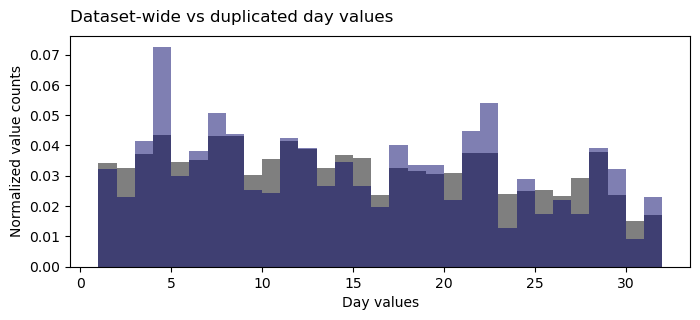

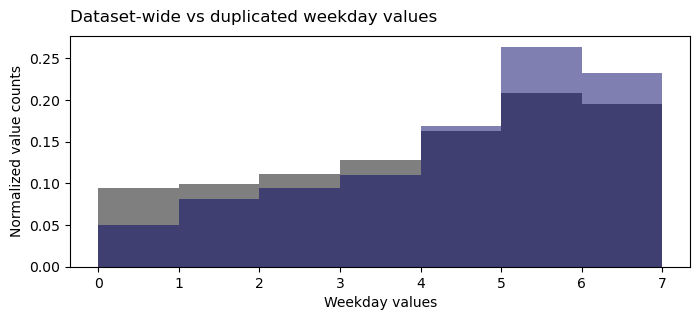

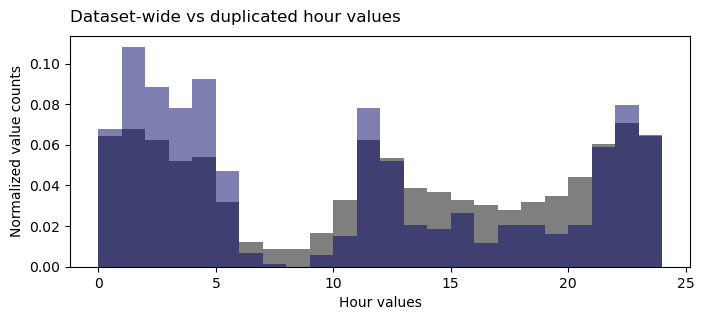

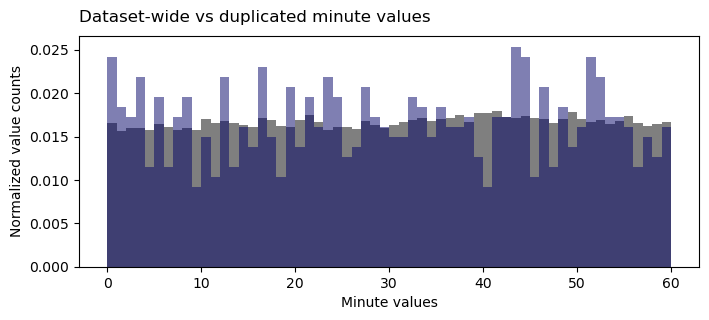

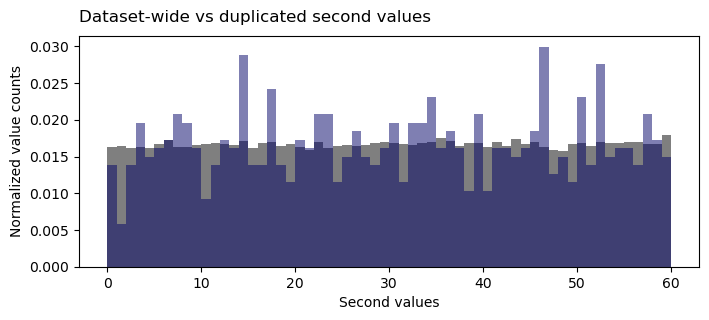

In [18]:
seconds = logins.login_time.dt.second.value_counts(normalize=True).sort_index()
duplicated_dates = duplicate_counts.index
for dt_component in ['day', 'weekday', 'hour', 'minute', 'second']:
    dataset_ratios = (
        getattr(logins.login_time.dt, dt_component)
        .value_counts(normalize=True).sort_index()
    )
    duplicated_ratios = (
        getattr(duplicated_dates.to_series().dt, dt_component)
        .value_counts(normalize=True).sort_index()
    )
    fig, ax = plt.subplots(figsize=(8, 3))
    to_plot = [
        ((0, 0, 0, 0.5), dataset_ratios, 'dataset'),
        ((0, 0, 0.4, 0.5), duplicated_ratios, 'duplicated')
    ]
    for color, ratios, label in to_plot:
        ax.bar(ratios.index, ratios, width=1, color=color, align='edge', label=label)
    set_plot_title(f'Dataset-wide vs duplicated {dt_component} values')
    ax.set_xlabel(f'{dt_component.title()} values')
    ax.set_ylabel('Normalized value counts')

Dataset-wide and duplicated-date distributions are comparable for all datetime component values depicted above. <br><br>
It may be useful to compare the number of duplicated records in a given period with the total number of observations in the same period. Add datetime features to the logins DataFrame to facilitate these and other comparisons.<br>

Add additional datetime features to the logins DataFrame.

In [19]:
logins.loc[:, 'date'] = logins.loc[:, 'login_time'].dt.date
logins.loc[:, 'day'] = logins.loc[:, 'login_time'].dt.day
logins.loc[:, 'year'] = logins.loc[:, 'login_time'].dt.year
logins.loc[:, 'month'] = logins.loc[:, 'login_time'].dt.month
logins.loc[:, 'month_name'] = logins.loc[:, 'login_time'].dt.strftime('%B')
logins.loc[:, 'week_of_month'] = logins.loc[:, 'login_time'].dt.day//7
logins.loc[:, 'day_of_month'] = logins.loc[:, 'login_time'].dt.day
logins.loc[:, 'weekday'] = logins.loc[:, 'login_time'].dt.weekday
logins.loc[:, 'weekday_name'] = logins.loc[:, 'login_time'].dt.strftime('%A')
logins.loc[:, 'hour'] = logins.loc[:, 'login_time'].dt.hour
logins.loc[:, 'hour_of_week'] = logins.loc[:, 'weekday'] * 24 + logins.loc[:, 'hour']
logins.loc[:, 'minute'] = logins.loc[:, 'login_time'].dt.minute
logins.loc[:, 'minute_of_day'] = logins.loc[:, 'hour'] * 60 + logins.loc[:, 'minute']
logins.loc[:, 'minute_of_week'] = (
    logins.loc[:, 'weekday'] *  24 * 60 + logins.loc[:, 'minute_of_day']
)
logins.loc[:, 'second'] = logins.loc[:, 'login_time'].dt.second
logins.loc[:, 'quarter_day'] = logins.loc[:, 'login_time'].dt.hour//6
logins.loc[:, 'quarter_hour'] = logins.loc[:, 'login_time'].dt.minute//15
logins.loc[:, 'quarter_hour_of_day'] = (
    logins.loc[:, 'quarter_hour'] + (4 * logins.loc[:, 'hour'])
)
logins.loc[:, 'is_weekend'] = logins.loc[:, 'login_time'].apply(is_weekend)
logins.loc[:, 'minute_of_dataset'] = (
    (
        logins.loc[:, 'login_time'] 
        - logins.loc[:, 'login_time'].min()
    ).dt.total_seconds()//60
)

Use the added features and DatetimeIndex created above to generate a scatterplot of unique and duplicated timestamp counts per 6 hour interval in the logins dataset's range.

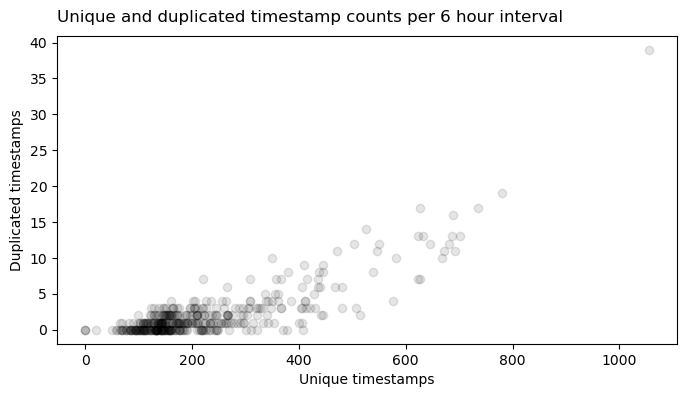

In [20]:
fig, ax = plt.subplots(figsize=(8, 4))
quarter_day_ind = pd.MultiIndex.from_product([logins_date_range, range(4)])
x = (
    logins.drop_duplicates().groupby(['date', 'quarter_day'])
    .login_time.count().reindex(quarter_day_ind, fill_value=0)
)
y = (
    logins[logins.login_time.duplicated(keep='first')]
    .groupby(['date', 'quarter_day']).login_time.count()
    .reindex(quarter_day_ind, fill_value=0)
)

ax.scatter(x, y, color=(0, 0, 0, 0.1))
set_plot_title('Unique and duplicated timestamp counts per 6 hour interval')
ax.set_xlabel('Unique timestamps'); ax.set_ylabel('Duplicated timestamps')
plt.show()
del x, y, quarter_day_ind

Each point in the figure shown above represents a 6 hour window in the logins DataFrame's range. The number of duplicated timestamps and unique timestamps during a particular window determine the point's projection on the X and Y axes, respectively.<br><br>
The number of duplicate timestamps in a given 6 hour window appears correlated with the number of unique logins in the same period.<br><br>
Generate bar plots of unique and duplicated timestamp counts per day. Scale each series to values in the range \[0, 1\] to enable comparison of trends on the same axes.

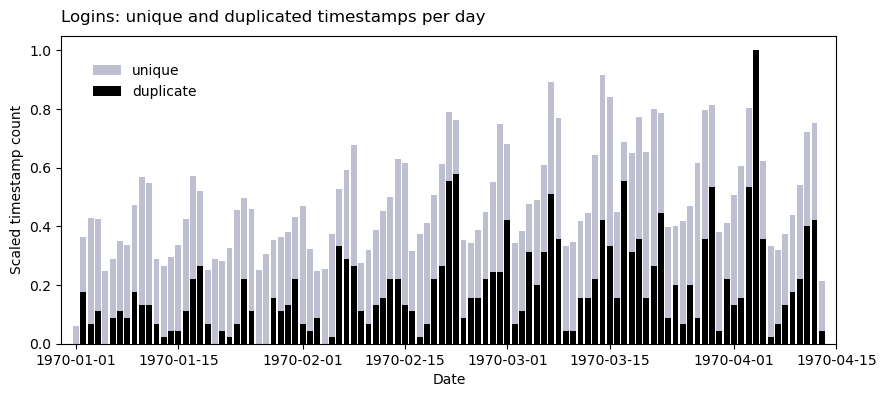

In [21]:
fig, ax = plt.subplots(figsize=(10, 4))
duplicates_by_date = (
    logins[logins.login_time.duplicated(keep='first')].groupby('date')
    .login_time.count().reindex(logins_date_range, fill_value=0)
)
unique_by_date = logins.groupby('date').login_time.nunique()

ax.bar(
    unique_by_date.index, unique_by_date/unique_by_date.max(),
    zorder=0, color=(0, 0, 0.3, 0.25), label='unique'
)
ax.bar(
    duplicates_by_date.index, duplicates_by_date/duplicates_by_date.max(), 
    color=(0, 0, 0), label='duplicate'
)
set_plot_title('Logins: unique and duplicated timestamps per day')
ax.set_ylabel('Scaled timestamp count')
ax.set_xlabel('Date')

ax.set_xlim(
    logins_date_range.min() - DateOffset(days=2), 
    logins_date_range.max() + DateOffset(days=2)
)
ax.legend(bbox_to_anchor=(0.025, 0.95), loc='upper left', frameon=False)
plt.show();

Duplicated record counts vary with unique record counts when timestamps in logins are grouped by date. A larger number of recorded unique timestamps in a given interval is strongly associated with a larger number of duplicate records. There is no significant difference in the apparent seasonality of the duplicated and unique timestamp counts per day. There is no  pattern, provided metadata, or domain-specific rule to suggest records with identical timestamps should be treated as erroneous or dropped. This is likely an artifact of the limited resolution of the recorded timestamps.<br><br>
As a final test, perform a similar comparison using timestamp counts grouped by hour.

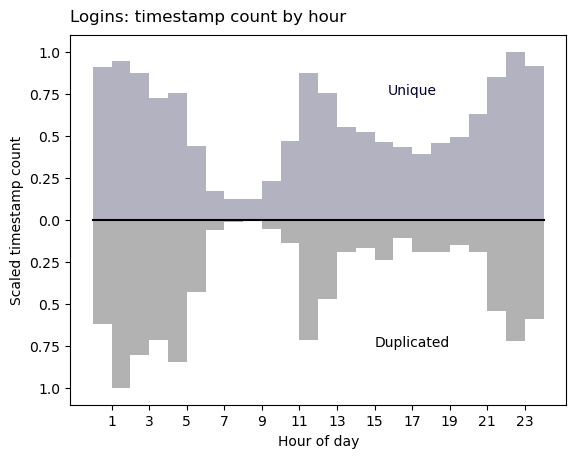

In [22]:
dup_mask = logins.login_time.duplicated(keep=False)
dup_counts = []
fig, ax = plt.subplots()
for mask, label, c in [(dup_mask, 'duplicated', -1), (~dup_mask, 'unique', 1)]:
    color = 'black' if label=='duplicated' else (0, 0, 0.2)
    counts = (
        logins[mask].groupby(logins.login_time.dt.hour).login_time.count()
    )
    counts = counts/counts.max()
    dup_counts.append(counts)
    ax.bar(
        counts.index, counts * c, bottom=0, width=1, align='edge',
        color=color, alpha=0.3
    )
    ax.text(17, 0.75 * c, label.title(), ha='center', color=color)
ax.plot([0, 24], [0, 0], color='black')
ax.set_yticks(ax.get_yticks(), np.abs(ax.get_yticks()))
ax.set_ylim(-1.1, 1.1)
ax.set_ylabel('Scaled timestamp count')
ax.set_xlabel('Hour of day')
ax.set_xticks(range(1, 25, 2), range(1, 25, 2))
set_plot_title('Logins: timestamp count by hour');

The ratio of unique to duplicated timestamp counts grouped by hour is extremely consistent. No records will be dropped.

### Exploratory data analysis<br>
Generate reports and visualizations to describe and depict various aspects of the logins dataset.<br>

Calculate summary statistics of login counts grouped by day.

In [23]:
print(f'login count per day: summary statistics\n{HR}')
login_count_by_date = (
    logins.login_time.dt.date.value_counts().to_frame().rename(
        columns={'login_time': 'login_count'})
)
for agg in ['min', 'max', 'mean', 'median', 'std']:
    print(
        f'{agg:<12}'
        + f'{methodcaller(agg)(login_count_by_date.login_count):>10.2f}'
    )
login_count_by_date_25th_ptile,  login_count_by_date_75th_ptile = (
    login_count_by_date.login_count.quantile([0.25, 0.75])
)
login_count_by_date_iqr = (
    login_count_by_date_75th_ptile- login_count_by_date_25th_ptile
)
login_count_by_date_ptiles = {
    '25th percentile': login_count_by_date_25th_ptile,
    'median': login_count_by_date.login_count.median(),
    '75th percentile': login_count_by_date_75th_ptile
}
print(f'{"iqr":<12}{login_count_by_date_iqr:10.2f}')


login count per day: summary statistics
-------------------------------------------------------------------------------
min             112.00
max            1889.00
mean            904.29
median          827.00
std             347.17
iqr             498.00


The number of logins per day varies widely within this datset; the standard deviation of the login count per day is roughly 70% of the interquartile range. The mean of the logins per day is skewed higher than the median. The maximum value of this dataset is over an order of magnitude greater than the minimum value. This data point is an outlier by many definitions.<br>

Print the login count, outlier type, extent above the 75th percentile or below the 25th percentile, and iqr ratio of each outlier in the login_count_by_date DataFrame created above.

In [24]:
login_count_by_date.join(
    outliers(login_count_by_date.login_count, return_type=[str, 'extent', 'ratio'])
).dropna()

,login_count,outlier_type,outlier_extent,outlier_ratio_iqr
1970-04-04,1889,high,1.0,1.502008


There is only one date in the logins dataset, April 4th, for which the login count is more than 1.5 times the interquartile range lower or higher than the 25th or 75th percentile, respectively. Perform the same tests using the mean and standard deviation of login counts per day. Include only days with login counts 2 or more times the standard deviation from the mean.

In [25]:
login_count_by_date_mean_std_outliers = outliers(
    login_count_by_date.login_count, reference='mean', threshold_multiple='std',
    threshold=2, return_type=[str, 'extent', 'ratio']
)
login_count_by_date_mean_std_outliers = (
    login_count_by_date_mean_std_outliers.reset_index()
    .rename(columns={'index': 'date'})
    .sort_values(by='date').set_index('date').dropna()
    .rename(columns={
        'outlier_type': 'outlier type', 
        'outlier_extent': 'residual',
        'outlier_ratio_std': 'std deviations from mean'
    }).round(2)
)

login_count_by_date_mean_std_outliers

,outlier type,residual,std deviations from mean
date,,,
1970-01-01,low,-97.96,-2.28
1970-03-07,high,67.37,2.19
1970-03-14,high,107.37,2.31
1970-04-04,high,290.37,2.84


Only 4 dates in the logins dataset have login counts that are further than 2 standard deviations from the mean. None of the dates in this dataset have login counts 3 or more times the standard deviation from the mean.<br><br>
Changes in login frequency due to holidays and weekends could easily explain differences observed so far.<br><br>
Use the login count by date to depict long term trends in the logins time series.

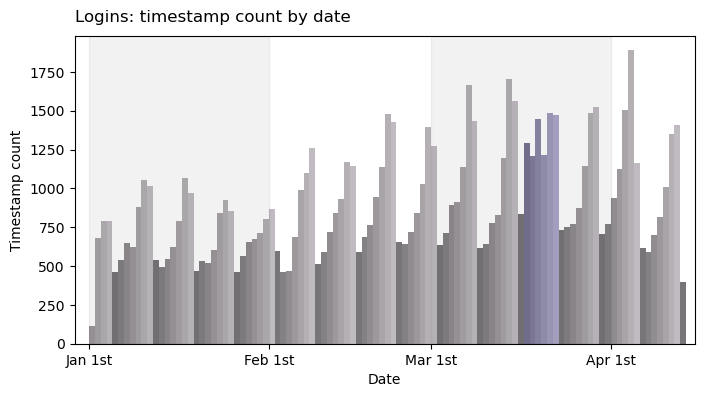

In [26]:
fig, ax = plt.subplots(figsize=(8, 4))

# Calculate login timestamp counts grouped by date
by_date = logins.groupby('date').login_time.count()

# Modulate bar color luminance by weekday
weekday_color = series_color(
    (by_date.index.to_series().astype(np.datetime64).dt.weekday + 10)/17, 
    [0.8, 0.78, 0.8], np.multiply
)
ax.bar(
    by_date.index, by_date, width=1, zorder=1,
    color=weekday_color, align='edge'
)

# Add dates to the x-axis tick labels
ticks = pd.Series(pd.date_range(
    logins.login_time.min().date(), logins.login_time.max().date(),
    freq='MS'
))
ax.set_xticks(ticks, ticks.dt.strftime('%b %d').str.replace('01', '1st'))
ylim = ax.get_ylim()

# Alternate background fill to show start and end of each month
for t_1, t_2 in pairwise([datetime(1970, m, 1) for m in range(1, 5)]):
    if t_1.month%2:
        ax.fill_betweenx(
            y=[0, ylim[1]], x1=[t_1], x2=[t_2], color=(0, 0, 0, 0.05)
        )
        
# Set plot boundaries to improve legibility
xlim= (
    np.array([datetime(1970, 1, 1), logins.login_time.max().date()])
    + np.array([DateOffset(days=-2.5), DateOffset(days=2.5)])
)
ax.set_xlim(xlim); ax.set_ylim(ylim)

# Highlight region of interest
for date_of_interest in pd.date_range(datetime(1970, 3, 17), datetime(1970, 3, 22)):
    ax.bar(
        date_of_interest, by_date.loc[date_of_interest.date()], 
        color=(0, 0, 1, 0.1), align='edge', width=1
    )
ax.set_xlabel('Date'); ax.set_ylabel('Timestamp count')
set_plot_title('Logins: timestamp count by date')

In the plot shown above, the background color and bar color are modulated to show the beginnings of distinct months and weeks, respectively. The weekly pattern exhibits apparent multiplicative seasonality. The variance of bar height in the plot above is dominated by this weekly pattern.<br><br>
An unusual increase in the number of timestamps logged per day occurs in the second to last week of march. The bars for this week are highlighted in purple. This may represent increased activity due to a holiday.<br><br>
Evaluation of this dataset over longer periods may be simplified by reducing variance due to the weekly pattern. Plot a rolling weekly average of the same data to highlight patterns and trends at longer periods.

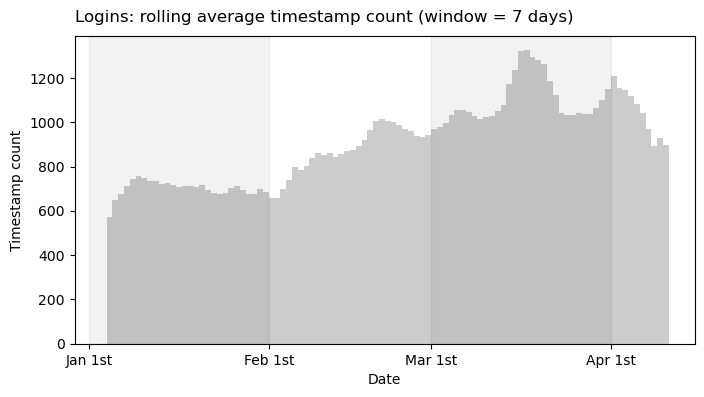

In [27]:
fig, ax = plt.subplots(figsize=(8, 4))
by_date_rolling = by_date.rolling(7, center=True).mean()
ax.bar(
    by_date_rolling.index, by_date_rolling, width=1, color=(0.8, 0.8, 0.8),
    align='edge'
)
set_plot_title('Logins: rolling average timestamp count (window = 7 days)')
ax.set_ylabel('Timestamp count'); ax.set_xlabel('Date')
ax.set_xticks(ticks, ticks.dt.strftime('%b %d').str.replace('01', '1st'))
ylim = ax.get_ylim()
for t_1, t_2 in pairwise([datetime(1970, m, 1) for m in range(1, 5)]):
    if t_1.month%2:
        ax.fill_betweenx(
            y=[0, ylim[1]], x1=[t_1], x2=[t_2], color=(0, 0, 0, 0.05)
        )
ax.set_ylim(ylim)
ax.set_xlim(xlim)
plt.show();

The plot shown above depicts a gradual increase in average logins over the course of this dataset's range, followed by a relatively steep decline in the beginning of April. This may simply be reversion to the mean following a period of unusually high logins counts. It may also be indicative of a negative autocorrelation coefficient over a long period. The possible causes and implications of the trends illustrated above have little meaning without additional information.<br><br>
Analyze the distribution of timestamp counts grouped by day.

Plot the empirical cumulative distribution function of daily login counts against that of a scaled standard normal distribution.

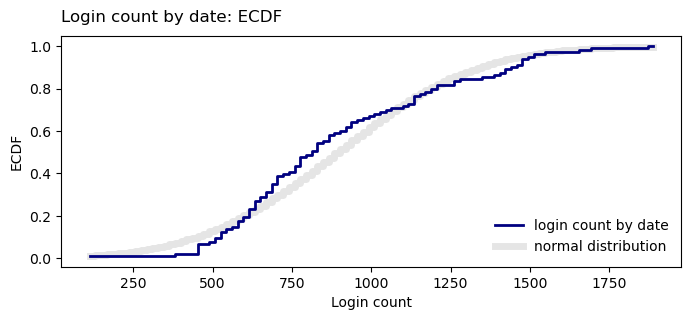

In [28]:
login_count_ecdf = sm.distributions.empirical_distribution.ECDF(
    login_count_by_date.login_count
)
normal_ecdf = sm.distributions.empirical_distribution.ECDF(
    np.random.normal(
        loc=login_count_by_date.login_count.mean(),
        scale=login_count_by_date.login_count.std(), 
        size=100000
    )
)
_x = np.linspace(*login_count_by_date.login_count.agg(['min', 'max']), 100)
fig, ax = plt.subplots(figsize=(8, 3))
set_plot_title('Login count by date: ECDF')
ax.set_xlabel('Login count'); ax.set_ylabel('ECDF')
ax.step(
    _x, login_count_ecdf(_x), color=(0, 0, 0.5), lw=2, zorder=1,
    label='login count by date'
)
ax.step(
    _x, normal_ecdf(_x), lw=5, color=(0, 0, 0, 0.1), zorder=0,
    label='normal distribution'
)
ax.legend(bbox_to_anchor=(1, 0), loc='lower right', frameon=False)
del _x, normal_ecdf, login_count_ecdf


The ECDF of login counts by date deviates from that of a scaled standard normal distribution. The ECDF of login counts by date somewhat resembles an intermediate of a standard normal and lognormal distribution.

Use bootstrapping to generate a histogram of the daily login count.

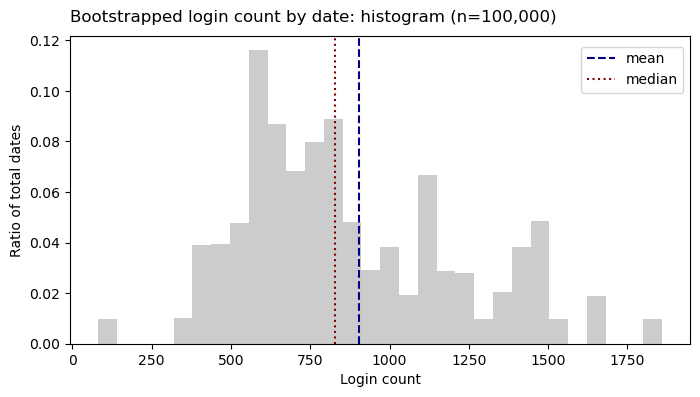

In [29]:
fig, ax = plt.subplots(figsize=(8, 4))
bootstrapped_daily_login_count = np.random.choice(
    login_count_by_date.login_count, 100000, replace=True
)
_h, _b = np.histogram(bootstrapped_daily_login_count, bins=30, density=True);
_w = abs(np.subtract(*_b[:2]))
bootstrapped_hist = pd.Series(index=_b[:-1], data=_h)
bootstrapped_hist = bootstrapped_hist/bootstrapped_hist.sum()
ax.bar(bootstrapped_hist.index, bootstrapped_hist, width=_w, color=(0, 0, 0, 0.2), zorder=0)
set_plot_title(f'Bootstrapped login count by date: histogram (n={100000:,.0f})')
ax.axvline(login_count_by_date.login_count.mean(), ls='--', color=(0, 0, 0.5), label='mean')
ax.axvline(login_count_by_date.login_count.median(), ls=':', color=(0.5, 0, 0), label='median')
ax.set_ylabel('Ratio of total dates'); ax.set_xlabel('Login count')
del _h, _b, bootstrapped_daily_login_count, bootstrapped_hist
fig.legend(bbox_to_anchor=[0.9, 0.87], loc='upper right')
plt.show();

The histogram depicted above somehwhat resembles a lognormal distribution. It also somewhat resembles a multimodal distribution that might arise from several locally normal distributions with means centered around the average demand during weekdays, weekends, and holidays. <br>

Perform seasonal decomposition of the timestamp count series grouped by day at a period width of one week. Plot the trend, seasonality, and residuals.

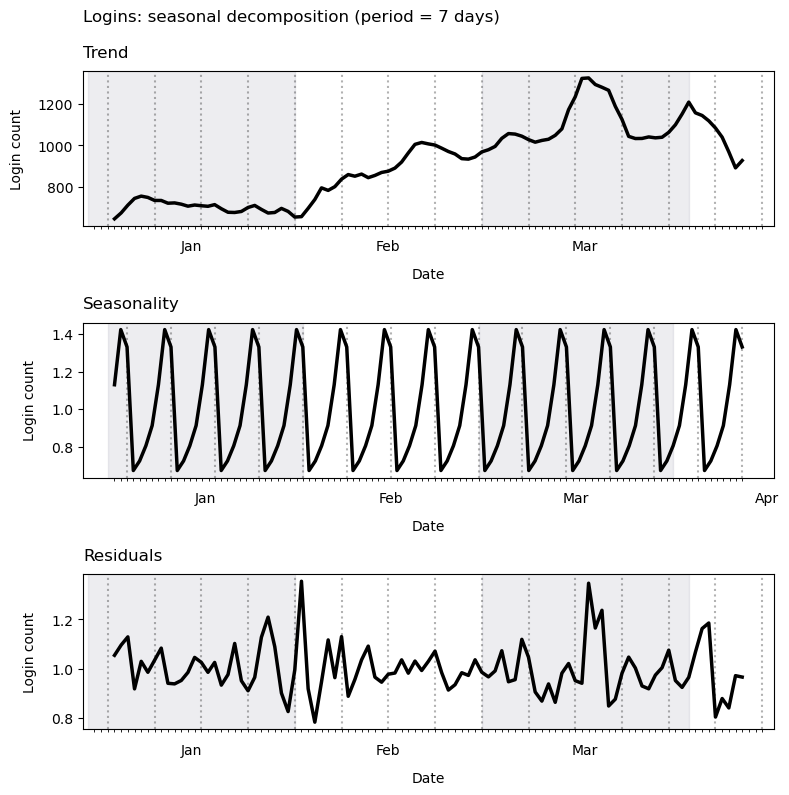

In [30]:
r_decomp = sm.tsa.seasonal_decompose(
    ( # Exclude incomplete days
        logins[not_1st_or_last].groupby('date').login_time.count()
    ), period=7, model='multiplicative'
)
r_seasonal, r_trend, r_resid = (
    (data, title, params) for data, title, params in zip(
        [r_decomp.seasonal, r_decomp.trend, r_decomp.resid],
        ['Seasonality', 'Trend', 'Residuals'], 
        [{'color': 'black', 'lw': 2.5}] * 3
    )
)
dates = pd.to_datetime(r_seasonal[0].index)
months = pd.Series([datetime(1970, n, 1, 0, 0, 0) for n in range(1, 6)])
month_centers = months[:-1] + (months.diff()[1:]/2).values

fig, axs = plt.subplots(3, 1, figsize=(8, 8))
fig.suptitle(
    'Logins: seasonal decomposition (period = 7 days)', x=0, y=1.3, 
    transform=axs[0].transAxes, ha='left', va='bottom'
)
for ax, (data, title, params) in zip(axs.flat, [r_trend, r_seasonal, r_resid]):
    ax.plot(data, **params)
    for i, date in enumerate(dates):
        if not (i - 2)%7:
            ax.axvline(date, ls=':', color=(0, 0, 0, 0.3))
    ylim, xlim = ax.get_ylim(), ax.get_xlim()
    for i, month in enumerate(pairwise(months), 1):
        if i%2:
            ax.fill_betweenx(ylim, *month, color=(0, 0, 0.2, 0.07))
    ax.set_title(title, x=0, loc='left', pad=10)
    ax.set_ylabel('Login count', labelpad=10); ax.set_xlabel('Date', labelpad=10)
    ax.set_xticks(month_centers, months[:-1].dt.strftime('%b'))
    ax.tick_params(axis='x', which='major', pad=10, length=0)
    ax.set_xticks(dates, minor=True)
    ax.set_xlim(xlim); ax.set_ylim(ylim); del ylim, xlim
fig.tight_layout()
plt.show();

Trend<br>
Grouped by day, login counts rise sharply at the beginning of the dataset and slowly decrease over the remainder of the first third of its dates. Login counts steadily increase during the middle third. The last third shows significantly more volatility, ending with a sharp decline. <br><br>
Seasonality<br>
A strong, remarkably consistent weekly pattern persists throughout the dataset.<br><br>
Residuals<br>
The residuals plot suggests login counts grouped by day may have a negative autocorrelation coefficient at periods of one to three days. The peaks in early February and early March align with relative troughs in the seasonal pattern.<br><br>

Create a dictionary pairing unique month values in logins with the length of the month in days. These key-value pairs may be used to determine when a login takes place relative to the beginning and end of the month in which it occurs.

In [31]:
logins_month_lengths ={
    month: monthrange(1970, month)[1]
    for month in logins.login_time.dt.month.unique()
}
print(f'logins: month lengths{BR}{HR}')
for month, num_days in logins_month_lengths.items():
    print(f'{f"{MONTH_MAP[month]} 1970:":>15}{num_days:>5} days')


logins: month lengths
-------------------------------------------------------------------------------
  January 1970:   31 days
 February 1970:   28 days
    March 1970:   31 days
    April 1970:   30 days


Create a second dictionary pairing each month in this dataset's range with the number of minutes in which observations were recorded. These values may be used to compare login counts grouped by month.

In [32]:
logins_month_observed_minutes = {
    i: logins_month_lengths[i] * 24 * 60 for i in [2, 3]
}
logins_month_observed_minutes[1] = (
    (
        datetime(
            year=1970, month=2, day=1, hour=0, minute=0, second=0
        ) 
        - logins[logins.month==1].login_time.min()
    ).total_seconds()//60
)
logins_month_observed_minutes[4] = (
    (
        logins[logins.month==4].login_time.max()
        - datetime(
            year=1970, month=4, day=1, hour=0, minute=0, second=0
        )
    ).total_seconds()//60
)
print(f'logins: observed minutes by month{BR}{HR}')
for month, num_minutes in logins_month_observed_minutes.items():
    print(f'{f"{MONTH_MAP[month]} 1970:":>15}{num_minutes:>8,.0f}')
    

logins: observed minutes by month
-------------------------------------------------------------------------------
 February 1970:  40,320
    March 1970:  44,640
  January 1970:  43,427
    April 1970:  18,417


Create a DatetimeIndex for the logins dataset's range with a frequency of one minute.

In [33]:
logins_minute_range = pd.date_range(
    datetime_floor(logins.login_time.min(), DateOffset(minutes=1)),
    datetime_floor(logins.login_time.max(), DateOffset(minutes=1)),
    freq='min'
)
print(f'logins datetime range{BR}{HR}')
for attr in ('size', 'resolution'):
    print(f'{attr:<15}{getattr(logins_minute_range, attr)}')

logins datetime range
-------------------------------------------------------------------------------
size           146806
resolution     minute


Create a Pandas Series of login counts by minute for all minutes in the range covered by the logins dataset.

In [34]:
logins_by_minute = (
    logins.sort_values(by='minute_of_dataset')
    .groupby('minute_of_dataset').login_time.count()
    .reindex(
        range(0, int(logins.minute_of_dataset.max() + 1)), 
        fill_value=0
    )
).to_frame()
logins_by_minute.set_index(
    logins_minute_range[:len(logins_by_minute)], inplace=True
)


Calculate rolling average login counts with a window size of fifteen minutes.

In [35]:
rolling_login_count = logins_by_minute.rolling(15, center=True)
rolling_mean_login_count = rolling_login_count.mean().dropna()

Generate bar plots of login counts at each of several discrete datetime intervals to facilitate analysis of underlying seasonal trends.

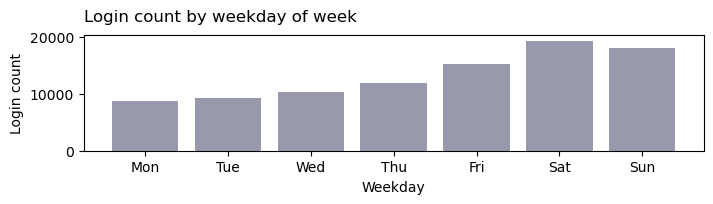

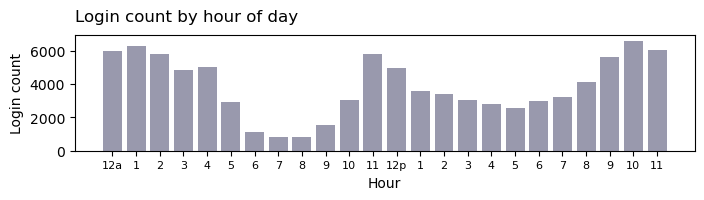

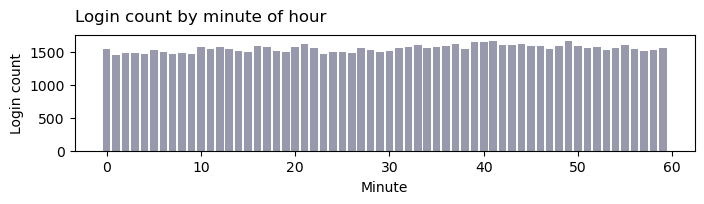

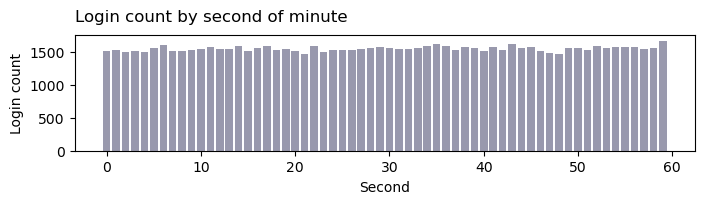

In [36]:
cycles = [
    ('week', 'weekday'), ('day', 'hour'),
    ('hour' ,'minute'), ('minute', 'second')
]
for duration, division in cycles:
    fig, ax = plt.subplots(figsize=(8, 1.5))
    counts = logins.groupby(division).login_time.count()
    ax.bar(counts.index, counts, color=(0, 0, 0.2, 0.4))
    set_plot_title(f'Login count by {division.replace("_", " ")} of {duration}')
    if division == 'weekday':
        ax.set_xticks(range(7), WEEKDAYS_ABBR)
    elif division == 'month':
        ax.set_xticks(range(1, 5), ['Jan', 'Feb', 'Mar', 'Apr'])
    elif division=='hour':
        ax.set_xticks(
            range(24), 
            ['12a', *map(str, range(1, 12)), '12p', *map(str, range(1, 12))],
            fontsize=8
        )
    ax.set_xlabel(division.title()); ax.set_ylabel('Login count')
    plt.show()
    del counts

Login counts exhibit strong seasonality at periods of one week and one day when grouped by day and hour, respectively.<br><br>
Compare the login by time of day of weekdays against that of weekends.

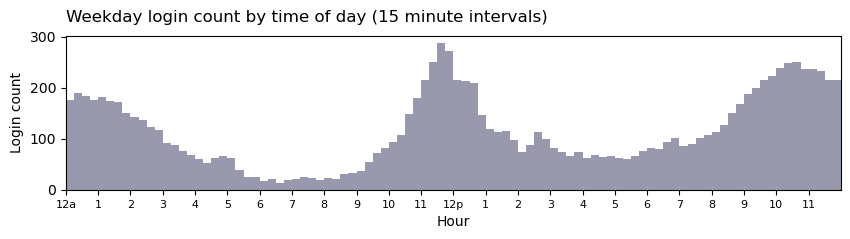

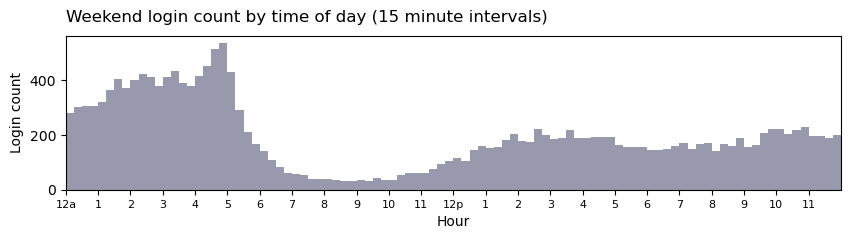

In [37]:
weekend_mask = logins.is_weekend
for mask, day_type, divisor in [(~weekend_mask, 'Weekday', 5), (weekend_mask, 'Weekend', 2)]:
    fig, ax = plt.subplots(figsize=(10, 2))
    counts = logins[mask].groupby(['quarter_hour_of_day']).login_time.count()/divisor
    ax.bar(counts.index/4, counts, color=(0, 0, 0.2, 0.4), width=0.25, align='edge')
    set_plot_title(f'{day_type} login count by time of day (15 minute intervals)')
    ax.set_xticks(
        range(24), 
        ['12a', *map(str, range(1, 12)), '12p', *map(str, range(1, 12))],
        fontsize=8
    )
    ax.set_xlabel('Hour'); ax.set_ylabel('Login count')
    ax.set_xlim(-0, 24)
    plt.show()
    del counts

The plots above illustrate distinct patterns in relative login frequency for weekends and weekends. As previously mentioned, more logins occur per hour on weekends than on weekdays. The scale of the y-axis in each of the above plots differs accordingly. Relative changes in logins per hour per day are easily observed by comparing bar heights horizontally in the plots above. Significantly more relative logins per hour per day occur on weekends than on weekdays between the hours of 12 and 4 AM. Weekday logins tend to peak around 1 1AM and 10 PM. Weekend logins have local maximums at 3 PM, 10 PM, and 4 AM.<br><br>
Apply the same visualization techniques to login counts by day of the week. Calculate counts by quarter hour.

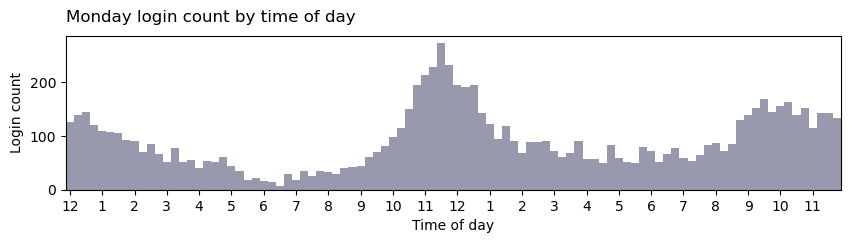

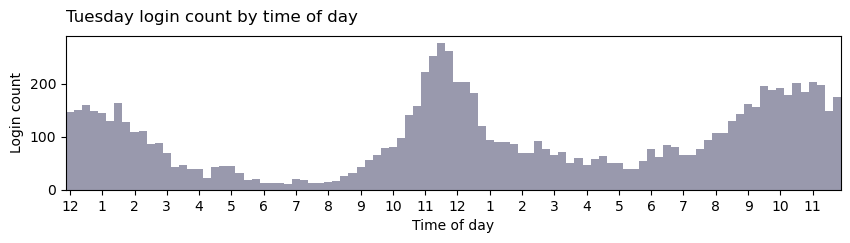

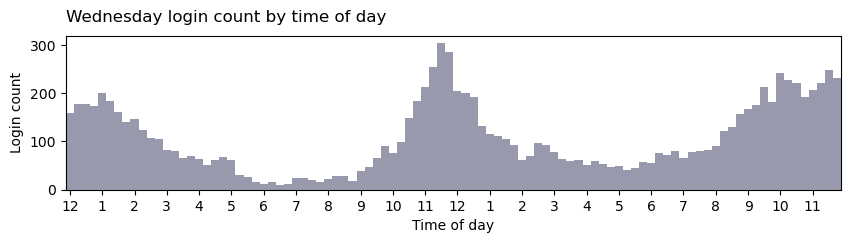

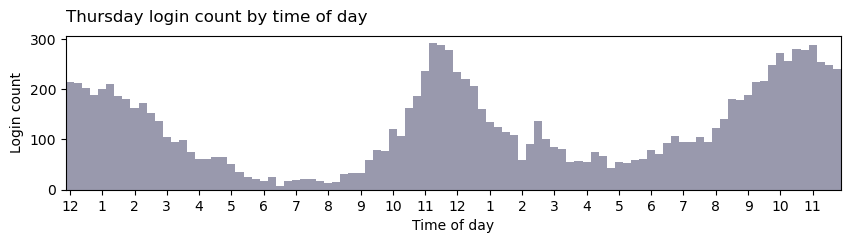

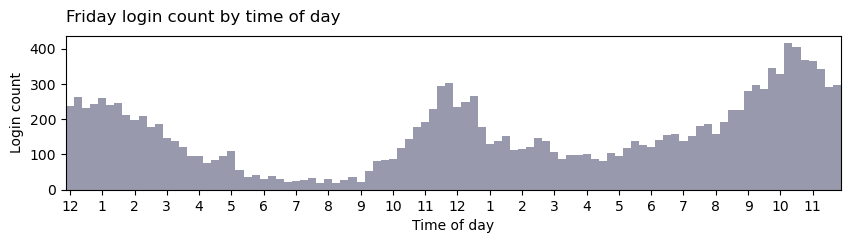

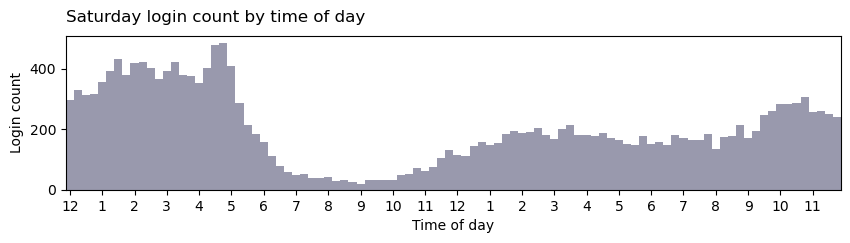

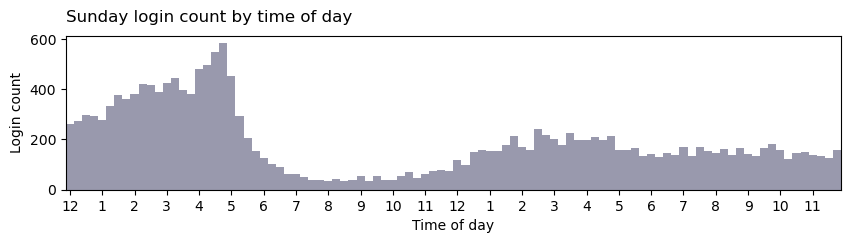

In [38]:
for weekday, day_name in WEEKDAY_MAP.items():
    subset_mask = logins.weekday==weekday
    counts = logins[subset_mask].groupby('quarter_hour_of_day').login_time.count()
    fig, ax = plt.subplots(figsize=(10, 2))
    set_plot_title(f'{day_name} login count by time of day')
    ax.bar(counts.index, counts, width=1, color=(0, 0, 0.2, 0.4))
    ax.set_xticks(range(0, 96, 4), [12, *range(1, 13), *range(1, 12)])
    ax.set_xlabel('Time of day'); ax.set_ylabel('Login count')
    ax.set_xlim(-0.5, 95.5)
    del subset_mask, counts
    plt.show();

Grouped at 15 minute intervals, there are three basic shapes depicted above. Monday through Thursday follow similar patterns. Saturday and Sunday follow similar curves. Friday follows a curve that is intermediate between the other two groups. In detail, all days from Friday to Sunday have distinct patterns.

Perform time series analysis by week.<br><br>
Create a selection mask to exclude weeks with incomplete data. Use this mask to calculate and plot login counts by week.

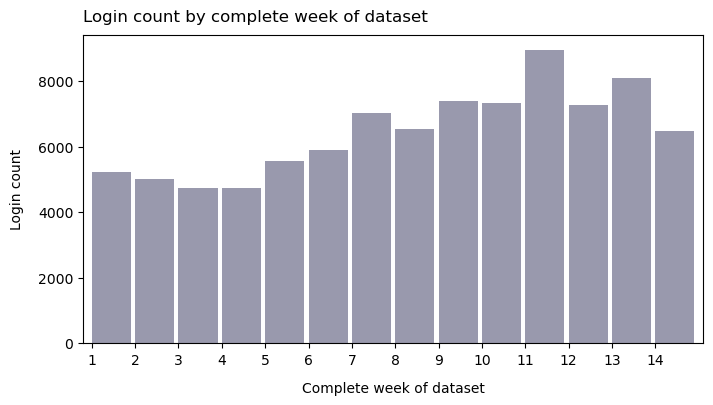

In [39]:
complete_weeks = (
    logins.login_time.dt.isocalendar().week
    .between(
        *logins.login_time.dt.isocalendar().week.agg(['min', 'max']), 
        inclusive='neither'
    )
)
count_by_week = (
    logins[complete_weeks]
    .groupby(logins.login_time.dt.isocalendar().week)
    .login_time.count()
)
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(
    count_by_week.index - 1, count_by_week, color=(0,0,0.2,0.4), 
    width=0.9, align='edge'
)
ax.set_xticks(range(1, 15)); ax.set_xlim(0.8, 15.1)
ax.set_xlabel('Complete week of dataset', labelpad=10)
ax.set_ylabel('Login count', labelpad=10)
set_plot_title('Login count by complete week of dataset');

The number of logins in a given week may be inversely correlated with that of the preceding week relative to a longer-term trend. Plot the difference of the values depicted above and a 3-week rolling average.

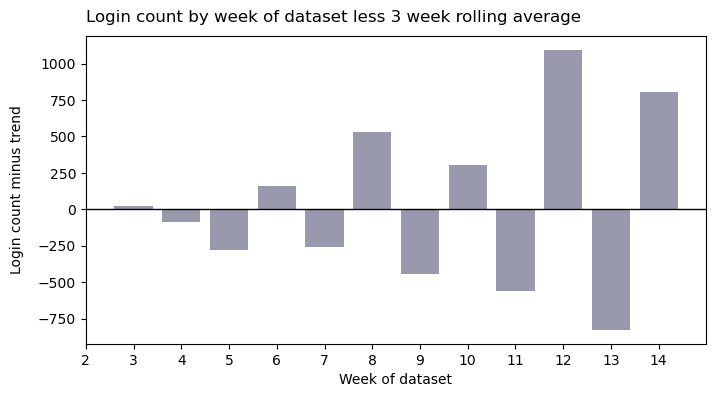

In [40]:
fig, ax = plt.subplots(figsize=(8, 4))
cbw_roll = count_by_week.rolling(3, center=True).mean()
ax.bar(cbw_roll.index, count_by_week - cbw_roll, color=(0,0,0.2,0.4))
set_plot_title('Login count by week of dataset less 3 week rolling average')
ax.set_xlabel('Week of dataset')
ax.set_ylabel('Login count minus trend', labelpad=10)
ax.set_xticks(range(2, 15))
ax.axhline(0, color=(0,0,0), lw=1, zorder=2);

Define a function to facilitate calculation of wrapped rolling login counts grouped by minute of the day.

In [41]:
def wrapped_rolling(data: pd.Series, window_size: int, *args, **kwargs):
    return pd.concat([
        data.iloc[-1 * window_size:],
        data,
        data.iloc[:window_size]
    ], axis=0).reset_index(drop=True).rolling(window_size, *args, **kwargs)
def wrapped_rolling_method(
            data: pd.Series, window_size: int, agg: str, 
            rolling_args: list=[], rolling_kwargs: dict={}, agg_args: list=[], 
            agg_kwargs: dict={}):
    return methodcaller(agg, *agg_args, **agg_kwargs)(
        wrapped_rolling(data, window_size, *rolling_args, **rolling_kwargs)
    ).reset_index(drop=True).iloc[window_size : -1 * window_size].reset_index(drop=True)
wrapped_rolling_mean = partial(wrapped_rolling_method, agg='mean')

Using a window size of fifteen minutes, plot rolling average login counts for each minute of the day. 

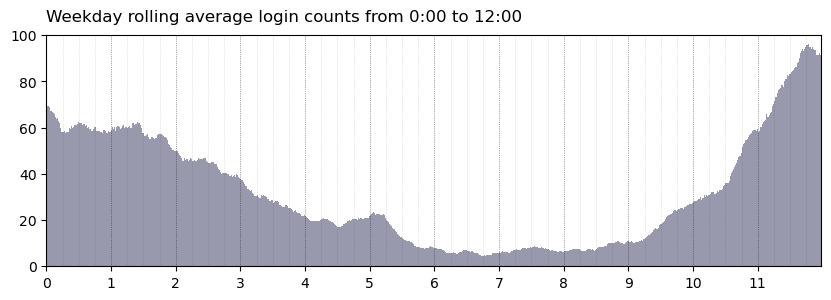

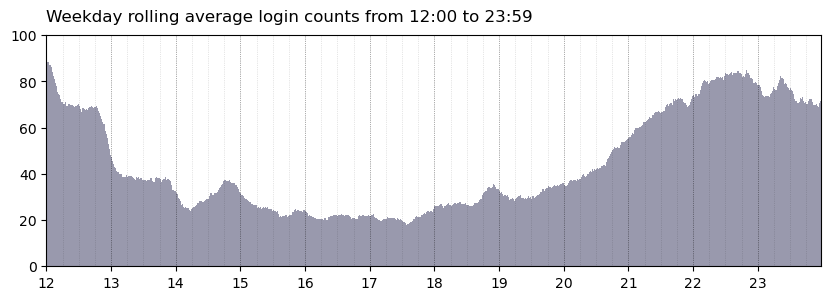

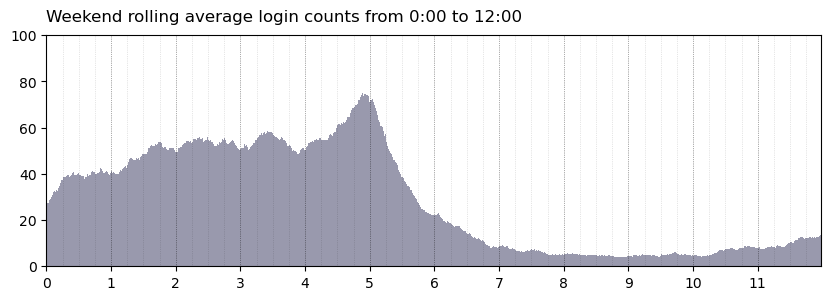

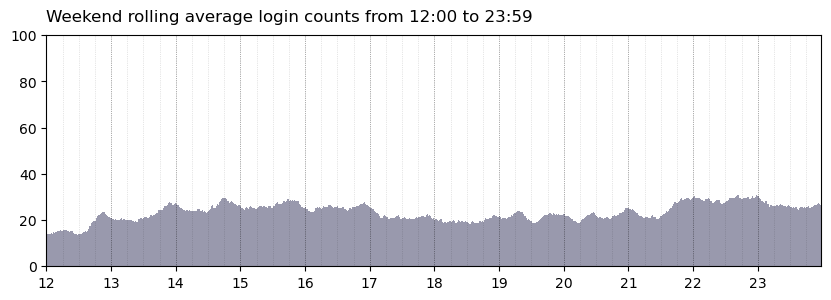

In [42]:
d = logins[not_1st_or_last]
by_day_type = {'Weekday': d[~d.is_weekend], 'Weekend': d[d.is_weekend]}
for day_type, data in by_day_type.items():
    logins_by_minute_of_day = data.groupby('minute_of_day').login_time.count()
    rolling_mean_logins_by_minute_of_day = wrapped_rolling_mean(
        logins_by_minute_of_day, window_size=15
    )
    subsets = dict(zip(
        ['from 0:00 to 12:00', 'from 12:00 to 23:59'],
        [rolling_mean_logins_by_minute_of_day.iloc[:720],
         rolling_mean_logins_by_minute_of_day.iloc[720:]]
    ))
    for i, (subset_name, subset) in enumerate(subsets.items()):
        fig, ax = plt.subplots(figsize=(10, 3))
        set_plot_title(
            f'{day_type} rolling average login counts {subset_name}'
        )
        ax.bar(
            subset.index, subset, align='edge', width=1, color=(0, 0, 0.2, 0.4)
        )
        x_range = np.arange(subset.index.min(), subset.index.min() + 60*13, 60)
        
        # Set axis ticks and grid lines
        ax.set_xticks(
            x_range, [f'{_/60:.0f}' if _/60 != 24 else '' for _ in x_range]
        )
        for hour in x_range:
            ax.axvline(hour, lw=0.5, ls=':', color=(0, 0, 0, 0.5))
            if hour != x_range.max():
                for minutes in range(hour, hour + 60, 15):
                    ax.axvline(minutes, lw=0.5, ls=':', color=(0, 0, 0, 0.2))
                    
        # Set uniform axis limits
        ax.set_xlim(subset.index.min(), subset.index.max())
        ax.set_ylim(0, 100)
        plt.show();
    del subsets, logins_by_minute_of_day, rolling_mean_logins_by_minute_of_day